In [ ]:
import numpy as np

In [ ]:

pde = lambda x,y,z, uxx, uyy, uzz , u, v, ut : 


lambda u, x2, x3, x4, ux1, ux2, ux3,ux4, ux2x2, ux3x3, ux4x4: ux1 + 1 * ux2 + 1 * ux3 + 0 * ux4 - .1*( ux2x2 + ux3x3 + ux4x4) -  ((torch.abs(x2)+torch.abs(x3)+torch.abs(x4-z0) < .000001).int() * q)

In [ ]:
z0 = 5
q = 100
D = 0.01
u=5
v=5
vz=1
vy=1
evaluate = lambda t,x,y,z : (q/(((2*np.pi)**1.5)*(vy**2)*(vz))) * np.exp(-1*((x-u*t)**2 + (y-v*t)**2)/(2*(vy**2))) * (np.exp((-1*(z-z0)**2)/(2*(vz**2))) + np.exp((-1*(z+z0)**2)/(2*(vz**2))))
def actual(t_input,x_input,y_input,z_input):
 result, error = quad((lambda x, y, z : lambda t : (evaluate(t,x,y,z)))(x_input,y_input,z_input), 0, t_input)
 return result

In [19]:
def laplacian_of_function(x, y, z, u, v, t, z0, vy, vz, q):
    # Original function components
    prefactor = q / (((2 * np.pi) ** 1.5) * (vy ** 2) * vz)
    exp_xy = np.exp(-((x - u * t) ** 2 + (y - v * t) ** 2) / (2 * (vy ** 2)))
    exp_z1 = np.exp(-((z - z0) ** 2) / (2 * (vz ** 2)))
    exp_z2 = np.exp(-((z + z0) ** 2) / (2 * (vz ** 2)))
    
    # Original function value
    f = prefactor * exp_xy * (exp_z1 + exp_z2)
    
    # Laplacian components for x and y
    laplacian_xy = f * (((x - u * t) ** 2 + (y - v * t) ** 2) / (vy ** 4) - (2 / (vy ** 2)))
    
    # Laplacian components for z
    laplacian_z = f * ((((z - z0) ** 2) / (vz ** 4)) - (1 / (vz ** 2)) + (((z + z0) ** 2) / (vz ** 4)) - (1 / (vz ** 2)))
    
    # Total Laplacian
    laplacian_f = laplacian_xy + laplacian_z
    
    return laplacian_f

In [3]:
x, y, z = 1.0, 1.0, 1.0  # Coordinates
u, v, t = 0.5, 0.5, 0  # Parameters related to motion and time
z0 = 0.2  # Offset in z-direction
vy, vz = 0.3, 0.4  # Velocity terms in y and z directions
q = 1.0  # Scaling factor or amplitude

# Calculate Laplacian
laplacian_result = laplacian_of_function(x, y, z, u, v, t, z0, vy, vz, q)



NameError: name 'laplacian_of_function' is not defined

In [19]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

# Define the Neural Network architecture
class PINN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers):
        super(PINN, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(num_hidden_layers)])
        self.output_layer = nn.Linear(hidden_size, output_size)
        self.activation = nn.Tanh()  # Tanh or ReLU activations are common

    def forward(self, x):
        x = self.activation(self.input_layer(x))
        for hidden in self.hidden_layers:
            x = self.activation(hidden(x))
        x = self.output_layer(x)
        return x

# Define the PDE residual for the Gaussian puff equation
def pde_residual(network, x, y, z, t, U, V, W, D):
    # Predict concentration C
    inputs = torch.cat([x, y, z, t], dim=1)
    C = network(inputs)

    # Compute gradients using automatic differentiation
    C_t = autograd.grad(C, t, torch.ones_like(C), create_graph=True)[0]
    C_x = autograd.grad(C, x, torch.ones_like(C), create_graph=True)[0]
    C_y = autograd.grad(C, y, torch.ones_like(C), create_graph=True)[0]
    C_z = autograd.grad(C, z, torch.ones_like(C), create_graph=True)[0]

    C_xx = autograd.grad(C_x, x, torch.ones_like(C_x), create_graph=True)[0]
    C_yy = autograd.grad(C_y, y, torch.ones_like(C_y), create_graph=True)[0]
    C_zz = autograd.grad(C_z, z, torch.ones_like(C_z), create_graph=True)[0]

    # PDE: C_t + U*C_x + V*C_y + W*C_z = D * (C_xx + C_yy + C_zz)
    pde = C_t + U * C_x + V * C_y + W * C_z - D * (C_xx + C_yy + C_zz)
    
    return pde

# Initialize the PINN model
input_size = 4  # x, y, z, t
hidden_size = 100
output_size = 1  # C
num_hidden_layers = 4

model = PINN(input_size, hidden_size, output_size, num_hidden_layers)

# Set up optimizer and hyperparameters
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Define the physics loss
def physics_loss(pinn_model, x, y, z, t, U, V, W, D):
    pde = pde_residual(pinn_model, x, y, z, t, U, V, W, D)
    return torch.mean(pde ** 2)

# Define boundary and initial conditions (if necessary)
def boundary_loss(pinn_model, x_b, y_b, z_b, t_b, C_true_b):
    inputs_b = torch.cat([x_b, y_b, z_b, t_b], dim=1)
    C_pred_b = pinn_model(inputs_b)
    return torch.mean((C_pred_b - C_true_b) ** 2)

# Training loop
num_epochs = 10000
U, V, W, D = 1.0, 1.0, 0, 0.1  # Velocities and diffusion coefficient

for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Sample points in the domain
    x = torch.rand(1000,1,requires_grad=True)*4  # Replace with actual domain sampling
    y = torch.rand(1000,1,requires_grad=True)*4
    z = torch.rand(1000,1,requires_grad=True)*4
    t = torch.rand(1000,1,requires_grad=True)*4

    # Compute the loss
    loss = physics_loss(model, x, y, z, t, U, V, W, D)

    # Optional: add boundary and initial condition loss
    # boundary_cond_loss = boundary_loss(pinn_model, x_b, y_b, z_b, t_b, C_true_b)
    # loss += boundary_cond_loss

    # Backpropagation and optimization step
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

print("Training complete.")


Epoch 0, Loss: 0.00011916229414055124
Epoch 100, Loss: 3.331035003384386e-08
Epoch 200, Loss: 1.1412406131228181e-08
Epoch 300, Loss: 7.308223359814292e-09
Epoch 400, Loss: 4.718267998526926e-09
Epoch 500, Loss: 4.112697293834344e-09
Epoch 600, Loss: 3.54452756035073e-09
Epoch 700, Loss: 2.846902935615958e-09
Epoch 800, Loss: 2.4373758567008963e-09
Epoch 900, Loss: 2.299272772177119e-09
Epoch 1000, Loss: 2.1165345032159166e-09
Epoch 1100, Loss: 2.0078858575800496e-09
Epoch 1200, Loss: 1.5588891288942364e-09
Epoch 1300, Loss: 1.6111741940605384e-09
Epoch 1400, Loss: 1.552657336034713e-09
Epoch 1500, Loss: 1.4504291101502531e-09
Epoch 1600, Loss: 1.2031089458020006e-09
Epoch 1700, Loss: 1.112756775611956e-09
Epoch 1800, Loss: 1.0573079078923797e-09
Epoch 1900, Loss: 1.1102589958511544e-09
Epoch 2000, Loss: 1.0258582872069155e-09
Epoch 2100, Loss: 1.0744460876566109e-09
Epoch 2200, Loss: 8.234957715735902e-10
Epoch 2300, Loss: 7.807533508596975e-10
Epoch 2400, Loss: 7.341856567144589e-10


KeyboardInterrupt: 

In [20]:
import numpy as np
x4 = np.linspace(0, 4, 5)
x2 = np.linspace(0, 4, 30)
x3 = np.linspace(0, 4, 30)
x1 = np.linspace(0, 4, 5)

u=10
v=10
vz=4
vy=1
# evaluate = lambda t,x,y,z : (q/(((2*np.pi)**1.5)*(vy**2)*vz)) * np.exp(-1*((x-u*t)**2 + (y-v*t)**2)/(2*vy**2)) * (np.exp((-1*(z-z0)**2)/(2*vz**2)) + np.exp((-1*(z+z0)**2)/(2*vz**2)))


# Create meshgrid
X1, X4, X2, X3 = np.meshgrid(x1, x4, x2, x3)

# Convert to torch tensors
X2_torch = torch.tensor(X2, dtype=torch.float32)
X3_torch = torch.tensor(X3, dtype=torch.float32)
X1_torch = torch.tensor(X1, dtype=torch.float32)
X4_torch = torch.tensor(X4, dtype=torch.float32)

# Flatten the tensors to create input for the model
X2_flat = X2_torch.view(-1, 1)
X3_flat = X3_torch.view(-1, 1)
X1_flat = X1_torch.view(-1, 1)
X4_flat = X4_torch.view(-1, 1)
X2_flat_np = X2_torch.view(-1, 1).detach().numpy()
X3_flat_np = X3_torch.view(-1, 1).detach().numpy()
X1_flat_np = X1_torch.view(-1, 1).detach().numpy()
X4_flat_np = X4_torch.view(-1, 1).detach().numpy()
# Predict Z using the model and reshape to match the meshgrid
U_flat = model(torch.concat([X1_flat, X2_flat, X3_flat,X4_flat],dim=1)).detach()
U = U_flat.view(X1.shape).numpy()
# print(X1_flat_np)
# U = np.array([actual(X1_flat_np[i],X2_flat_np[i],X3_flat_np[i],X4_flat_np[i]) for i in range(len(X2_flat_np))]).reshape(X1.shape)
global_min = np.min(U)
global_max = np.max(U)


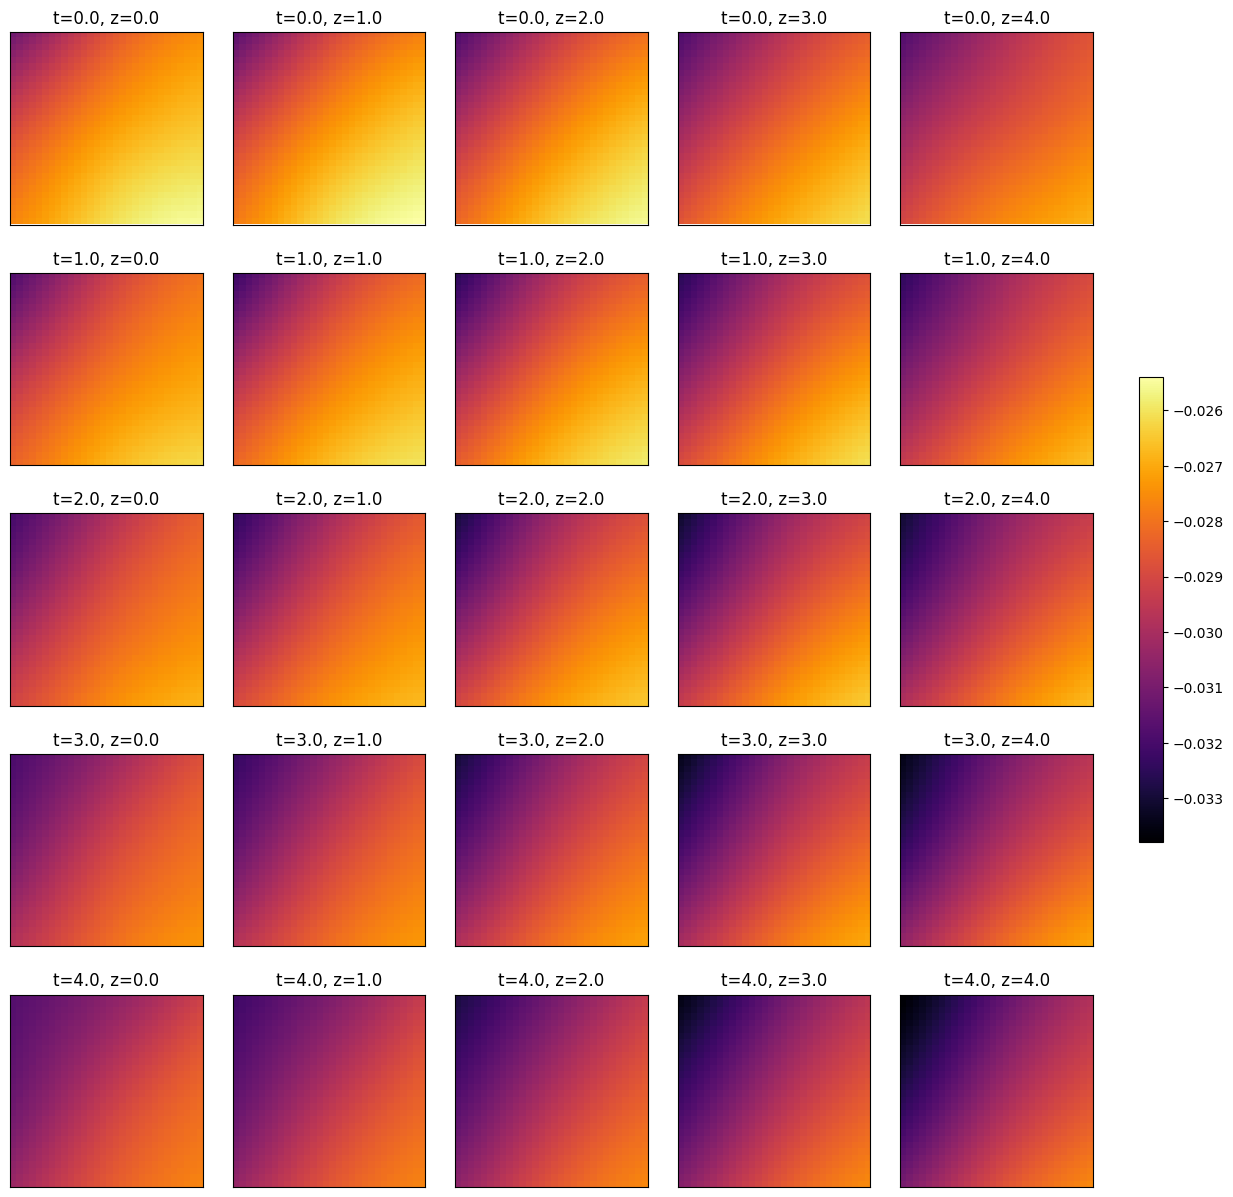

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle


length = len(x1)
width = len(x4)
# Create a grid of subplots (4 rows x 5 columns)
fig, axs = plt.subplots(length, width, figsize=(15,15))

# Simulated example data (replace this with your actual data)
for i, ax in enumerate(axs.flat):
    j = i // width
    i = i % width
    data = U[i][j]
    im = ax.imshow(data, cmap='inferno', interpolation='nearest', vmin=global_min, vmax=global_max)
    
    # Remove axis labels
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Add a time label at the top of each column
    
    ax.set_title(f't={round(x1[j],2)}, z={round(x4[i],2)}')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=.25)
fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
# Show the plot
plt.show()